In [1]:
# Standard imports:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Data reading and pre-processing

In [2]:
df_train=pd.read_csv('input/train_clean.csv')
df_val=pd.read_csv('input/val_clean.csv')

## WordCloud visualization:

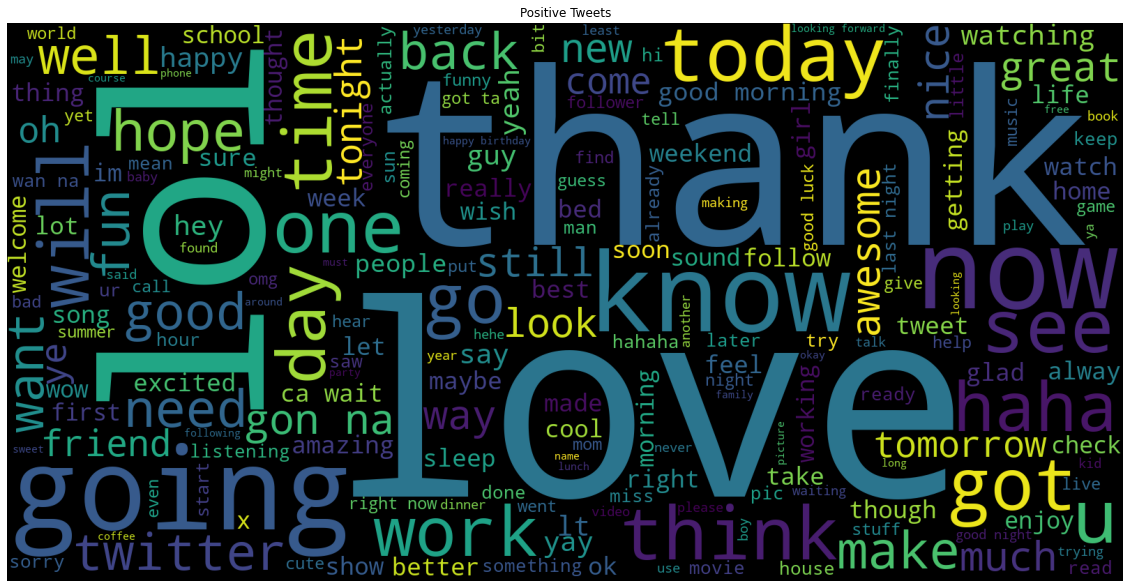

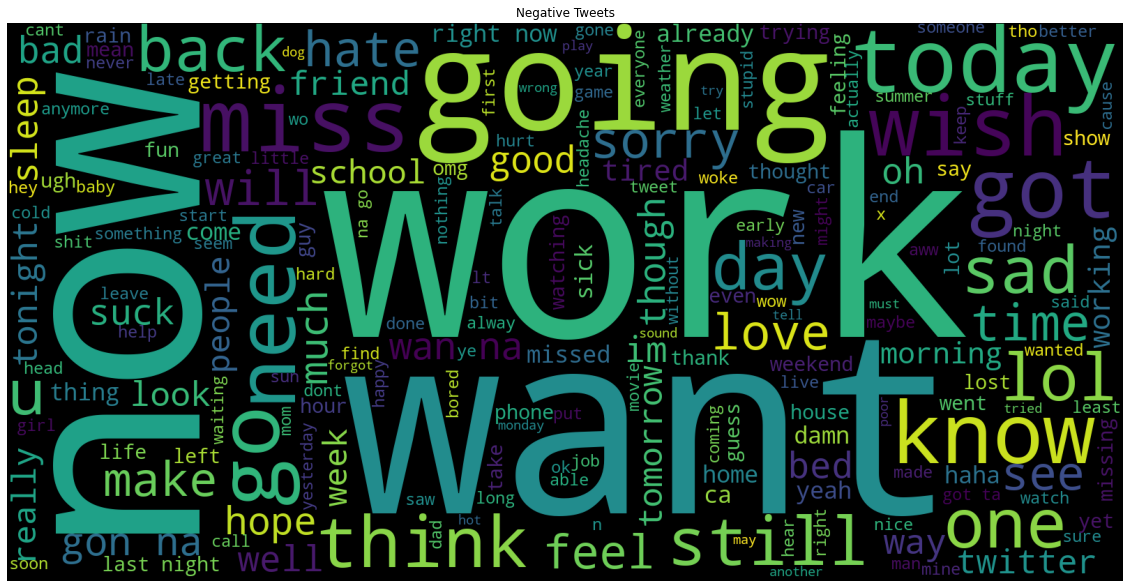

In [3]:
from wordcloud import WordCloud

df_pos = df_train.loc[df_train["Label"] == 1]
df_neg = df_train.loc[df_train["Label"] == 0]

wc_pos = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_pos["Text"])) 

wc_neg = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_neg["Text"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Tweets")
plt.axis("off")
plt.show()

In [4]:
# Add common words as stopwords
n_sw = 50 # Add n_sw of the top common words as stop words
top_pos = list(wc_pos.words_.keys()) # Sorted in decr order of frequencies, len=200
top_neg = list(wc_neg.words_.keys())
common = list(set(top_pos[:n_sw]) & set(top_neg[:n_sw]))
print(common)

['well', 'see', 'got', 'u', 'oh', 'hope', 'tomorrow', 'today', 'still', 'work', 'twitter', 'love', 'look', 'think', 'friend', 'want', 'good', 'need', 'know', 'tonight', 'one', 'lol', 'now', 'day', 'back', 'make', 'way', 'going', 'gon na', 'go', 'time', 'much', 'will']


In [5]:
# Only select some, as others are meaningful
common = ["amp", "quot", "lol" "u"]

## Analyze the length of the tweets:
This will help us select the `N_SEQ`

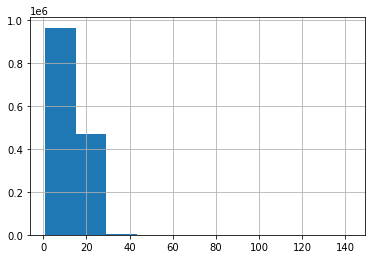

Mean: 12.5148
Std: 6.8897
Mean+3*Std = 33.1840


In [6]:
lengths = df_train["Text"].apply(lambda x : len(x.split(" "))) # try mean + 3*sigma
lengths.hist()
plt.show()

mean = lengths.mean()
std = lengths.std()
approx_nseq = mean + 3*std
print(f"Mean: {mean:.4f}\nStd: {std:.4f}\nMean+3*Std = {approx_nseq:.4f}")

Thus we keep `N_SEQ = 32` (Power of 2)

In [7]:
N_SEQ = 32

## Preparation before model training

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

In [9]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:N_SEQ-2]
    return tokens

In [10]:
from torchtext.legacy import data
import torch
TEXT = data.Field(batch_first = True,
                  use_vocab=False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float,use_vocab=False)
fields=[("Label",LABEL),("Text",TEXT)]


In [11]:
train_data = data.TabularDataset('input/train_clean.csv', format='csv',fields=fields,skip_header=True)
val_data = data.TabularDataset('input/val_clean.csv', format='csv',fields=fields,skip_header=True)

In [12]:
N_BATCH = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device='cpu'
print(device)

cuda


In [13]:
loader_val = data.BucketIterator(val_data, batch_size=N_BATCH,shuffle=True,device=device)
loader_train = data.BucketIterator(train_data, batch_size=N_BATCH,shuffle=True,device=device)

## Preparing the Embeddings

In [14]:
import torch

## The Model:
Based on [this](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb) tutorial

In [15]:
N_EPOCHS = 20
OUTPUT_DIM = 1
HIDDEN_DIM = 64 # Output dimension of the LSTM
lr=0.00005

### Utility functions:

In [16]:
def countParameters(model):
    """ Counts the total number of trainiable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

In [17]:
import torch.nn.functional as F

def binary_accuracy(logits, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # Round predictions to the closest integer
    preds = torch.sigmoid(logits)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
def train(model, iterator, optimizer, criterion):
    """ Trains the model on the given training set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # Tells your model that you are training the model
    
    for text, labels in iterator:
        
        # https://discuss.pytorch.org/t/how-to-add-to-attribute-to-dataset/86468
        text = text.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # Zero the previous gradients
        
        logits = model(text)
        labels = labels.type_as(logits).unsqueeze(1)
        
        loss = criterion(logits, labels)
        acc = binary_accuracy(logits, labels)
        
        loss.backward() # Compute gradients
        
        optimizer.step() # Make the updates
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    """ Evaluates the model on the validation set """
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # Tells the model that we are currently evaluating the model
    
    with torch.no_grad(): # Temporarily set all the requires_grad flag to false
    
        for text, labels in iterator:
            
            text = text.to(device)
            labels = labels.to(device)

            logits = model(text)
            labels = labels.type_as(logits).unsqueeze(1)
            
            loss = criterion(logits, labels)
            acc = binary_accuracy(logits, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [21]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
from torch import nn
class Model(nn.Module):
    
    def __init__(self, bert, hidden_dim, output_dim,bidirectional=True, dropout = 0.2):
        
        super().__init__()
        # Embedding
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        # BiLSTM
        self.rnn = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers = 2,
            bidirectional = bidirectional, 
            dropout = dropout, # adds dropout on the connections between hidden states in one layer to hidden states in the next layer.
            batch_first = True
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim) # As bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # Embedding of the given "text" represented as a vector
        with torch.no_grad():
            embedded = self.bert(text)[0]

        # LSTM output
        lstm_output, (ht, cell) = self.rnn(embedded) # [batch size, sent len, hid dim], [ batch size, 1, hid dim]
        # Compute attention:

        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((ht[-2,:,:], ht[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(ht[-1,:,:])
        # Classifer:
        output = self.fc(hidden)
        
        return output # No need for sigmoid, our loss function will apply that for us

In [23]:
model = Model(bert, HIDDEN_DIM, OUTPUT_DIM)
trainable, frozen = countParameters(model)

print(model)
print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

In [24]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False
        
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
fc.weight
fc.bias


In [25]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss() # Binary crossentropy: This computes sigma(logits) too, much more numerically stable

model = model.to(device)
criterion = criterion.to(device)

In [26]:
# The actual training and validation:

best_valid_loss = float("inf")

history = {
    "t_loss" : [],
    "v_loss" : [],
    "t_acc" : [],
    "v_acc" : []
}

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, loader_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, loader_val, criterion)
    
    end_time = time.time()
    
    history["t_loss"].append(train_loss)
    history["v_loss"].append(valid_loss)
    history["t_acc"].append(train_acc)
    history["v_acc"].append(valid_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Saves best only
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
    
    # Print details about each epoch:
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

Epoch: 01 | Epoch Time: 25m 51s
	Train Loss: 0.482 | Train Acc: 76.72%
	 Val. Loss: 0.440 |  Val. Acc: 79.78%
Epoch: 02 | Epoch Time: 25m 51s
	Train Loss: 0.439 | Train Acc: 79.54%
	 Val. Loss: 0.408 |  Val. Acc: 81.27%
Epoch: 03 | Epoch Time: 25m 51s
	Train Loss: 0.421 | Train Acc: 80.60%
	 Val. Loss: 0.400 |  Val. Acc: 81.90%
Epoch: 04 | Epoch Time: 25m 46s
	Train Loss: 0.410 | Train Acc: 81.23%
	 Val. Loss: 0.390 |  Val. Acc: 82.35%
Epoch: 05 | Epoch Time: 25m 46s
	Train Loss: 0.402 | Train Acc: 81.71%
	 Val. Loss: 0.385 |  Val. Acc: 82.68%
Epoch: 06 | Epoch Time: 25m 46s
	Train Loss: 0.396 | Train Acc: 82.03%
	 Val. Loss: 0.384 |  Val. Acc: 82.86%
Epoch: 07 | Epoch Time: 25m 48s
	Train Loss: 0.391 | Train Acc: 82.29%
	 Val. Loss: 0.379 |  Val. Acc: 83.11%
Epoch: 08 | Epoch Time: 25m 44s
	Train Loss: 0.387 | Train Acc: 82.55%
	 Val. Loss: 0.374 |  Val. Acc: 83.23%
Epoch: 09 | Epoch Time: 25m 45s
	Train Loss: 0.383 | Train Acc: 82.73%
	 Val. Loss: 0.375 |  Val. Acc: 83.30%
Epoch: 10 

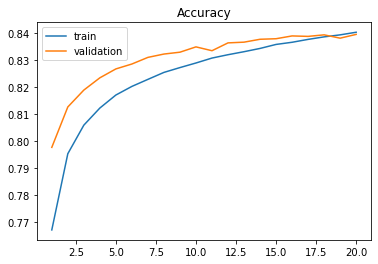

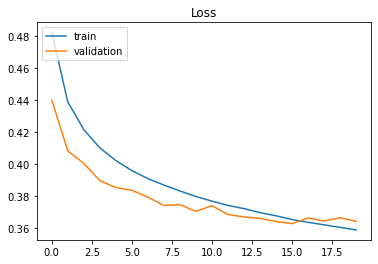

In [27]:
# Plots

t_acc = history["t_acc"]
t_loss = history["t_loss"]
v_acc = history["v_acc"]
v_loss = history["v_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")
plt.legend(['train', 'validation'], loc='upper left')

plt.show()